## 1. Importing libraries

In [138]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    StandardScaler,
    OrdinalEncoder
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [2]:
pd.set_option('display.max_columns', None) # To show all columns

In [3]:
sklearn.set_config(transform_output='pandas') # To show all output to pandas

In [4]:
warnings.filterwarnings('ignore') # To ignore warnings

## 3. Read the data

In [5]:
path = r"D:\Projects\Machine Learning\Flight Price Prediction\data\train.csv"
train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-09,Kolkata,Banglore,14:05:00,12:00:00,1315,1.0,In-flight meal not included,9663
1,Jet Airways,2019-06-06,Kolkata,Banglore,18:55:00,04:40:00,585,1.0,In-flight meal not included,7757
2,Indigo,2019-05-12,Banglore,Delhi,10:10:00,13:00:00,170,0.0,No Info,3943
3,Air Asia,2019-04-09,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
4,Spicejet,2019-06-01,Kolkata,Banglore,06:55:00,09:30:00,155,0.0,No Info,3873
...,...,...,...,...,...,...,...,...,...,...
635,Spicejet,2019-04-15,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No Info,5830
636,Multiple Carriers,2019-06-01,Delhi,Cochin,12:50:00,01:30:00,760,1.0,No Info,6795
637,Jet Airways,2019-05-12,Kolkata,Banglore,20:25:00,18:00:00,1295,1.0,No Info,14151
638,Indigo,2019-06-12,Chennai,Kolkata,22:05:00,00:25:00,140,0.0,No Info,5277


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train = train.drop(columns='price')  # excluding price column
y_train = train.price.copy()           # inlcluding only price column

## 4. Transformation operations

In [8]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 airline

In [9]:
X_train.airline

0            Jet Airways
1            Jet Airways
2                 Indigo
3               Air Asia
4               Spicejet
             ...        
635             Spicejet
636    Multiple Carriers
637          Jet Airways
638               Indigo
639               Indigo
Name: airline, Length: 640, dtype: object

In [23]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ('grouper', RareLabelEncoder(tol=0.1, replace_with='other', n_categories=2)),
    ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
air_transformer.fit_transform(X_train.loc[:, ['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0
636,0.0,0.0,0.0,1.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,1.0,0.0,0.0,0.0


### 4.2 date of journey

In [43]:
train.date_of_journey

0      2019-05-09
1      2019-06-06
2      2019-05-12
3      2019-04-09
4      2019-06-01
          ...    
635    2019-04-15
636    2019-06-01
637    2019-05-12
638    2019-06-12
639    2019-05-09
Name: date_of_journey, Length: 640, dtype: object

In [48]:
feature_to_extract = ['month', 'week', 'day_of_week', 'day_of_year']

doj_transformer = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format='mixed')),
    ('scaler', MinMaxScaler())

])

doj_transformer.fit_transform(X_train.loc[:, ['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.588235,0.500000,0.584746
1,1.000000,0.823529,0.500000,0.822034
2,0.666667,0.588235,1.000000,0.610169
3,0.333333,0.352941,0.166667,0.330508
4,1.000000,0.764706,0.833333,0.779661
...,...,...,...,...
635,0.333333,0.411765,0.000000,0.381356
636,1.000000,0.764706,0.833333,0.779661
637,0.666667,0.588235,1.000000,0.610169
638,1.000000,0.882353,0.333333,0.872881


### 4.3 source & destination

In [50]:
X_train.source

0       Kolkata
1       Kolkata
2      Banglore
3      Banglore
4       Kolkata
         ...   
635       Delhi
636       Delhi
637     Kolkata
638     Chennai
639       Delhi
Name: source, Length: 640, dtype: object

In [51]:
X_train.destination

0      Banglore
1      Banglore
2         Delhi
3         Delhi
4      Banglore
         ...   
635      Cochin
636      Cochin
637    Banglore
638     Kolkata
639      Cochin
Name: destination, Length: 640, dtype: object

In [52]:
location_subset = X_train.loc[:, ['source', 'destination']]
location_subset

,source,destination
0,Kolkata,Banglore
1,Kolkata,Banglore
2,Banglore,Delhi
3,Banglore,Delhi
4,Kolkata,Banglore
...,...,...
635,Delhi,Cochin
636,Delhi,Cochin
637,Kolkata,Banglore
638,Chennai,Kolkata


In [59]:
location_pipe1 = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, replace_with='Others', n_categories=2)),
    ('encoder', MeanEncoder()),
    ('scaler', PowerTransformer()),
    
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.421157,-0.434646
1,-0.421157,-0.434646
2,-0.756979,-1.579379
3,-0.756979,-1.579379
4,-0.421157,-0.434646
...,...,...
635,1.089421,0.741943
636,1.089421,0.741943
637,-0.421157,-0.434646
638,-1.919848,-1.583516


In [61]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [65]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi', 'Kolkata', 'Mumbai', 'New Delhi']
    return (
        X
        .assign(**{
            f'{col}_is_north': X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,0,1


In [67]:
location_transformer = FeatureUnion(transformer_list=[
    ('part1', location_pipe1),
    ('part2', FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.421157,-0.434646,1,0
1,-0.421157,-0.434646,1,0
2,-0.756979,-1.579379,0,1
3,-0.756979,-1.579379,0,1
4,-0.421157,-0.434646,1,0
...,...,...,...,...
635,1.089421,0.741943,1,0
636,1.089421,0.741943,1,0
637,-0.421157,-0.434646,1,0
638,-1.919848,-1.583516,0,1


### 4.4 dep_time & arrival_time

In [72]:
X_train.dep_time

0      14:05:00
1      18:55:00
2      10:10:00
3      04:55:00
4      06:55:00
         ...   
635    08:45:00
636    12:50:00
637    20:25:00
638    22:05:00
639    06:50:00
Name: dep_time, Length: 640, dtype: object

In [73]:
X_train.arrival_time

0      12:00:00
1      04:40:00
2      13:00:00
3      07:45:00
4      09:30:00
         ...   
635    13:15:00
636    01:30:00
637    18:00:00
638    00:25:00
639    16:10:00
Name: arrival_time, Length: 640, dtype: object

In [77]:
time_subset = X_train[['dep_time', 'arrival_time']]
time_subset

,dep_time,arrival_time
0,14:05:00,12:00:00
1,18:55:00,04:40:00
2,10:10:00,13:00:00
3,04:55:00,07:45:00
4,06:55:00,09:30:00
...,...,...
635,08:45:00,13:15:00
636,12:50:00,01:30:00
637,20:25:00,18:00:00
638,22:05:00,00:25:00


In [80]:
time_pipe1 = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=['hour', 'minute'])),
    ('scaler', MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.608696,0.090909,0.521739,0.000000
1,0.782609,1.000000,0.173913,0.727273
2,0.434783,0.181818,0.565217,0.000000
3,0.173913,1.000000,0.304348,0.818182
4,0.260870,1.000000,0.391304,0.545455
...,...,...,...,...
635,0.347826,0.818182,0.565217,0.272727
636,0.521739,0.909091,0.043478,0.545455
637,0.869565,0.454545,0.782609,0.000000
638,0.956522,0.090909,0.000000,0.454545


In [84]:
def part_of_day(X, morning=4, noon=12, eve=4, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })
    return(
        X_temp
        .assign(**{
            f'{col}_part_of_day':np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive='left'),
                 X_temp.loc[:, col].between(noon, eve, inclusive='left'),
                 X_temp.loc[:, col].between(eve, night, inclusive='left')],
                ['morning', 'afternoon', 'evening'],
                default='night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,evening
1,evening,morning
2,morning,evening
3,morning,morning
4,morning,morning
...,...,...
635,morning,evening
636,evening,night
637,night,evening
638,night,night


In [87]:
time_pipe2 = Pipeline(steps=[
    ('part', FunctionTransformer(func=part_of_day)),
    ('encoder', CountFrequencyEncoder()),
    ('scaler', MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.513228,1.000000
1,0.513228,0.000000
2,1.000000,1.000000
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
635,1.000000,1.000000
636,0.513228,0.190476
637,0.000000,1.000000
638,0.000000,0.190476


In [88]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1', time_pipe1),
    ('part2', time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.608696,0.090909,0.521739,0.000000,0.513228,1.000000
1,0.782609,1.000000,0.173913,0.727273,0.513228,0.000000
2,0.434783,0.181818,0.565217,0.000000,1.000000,1.000000
3,0.173913,1.000000,0.304348,0.818182,1.000000,0.000000
4,0.260870,1.000000,0.391304,0.545455,1.000000,0.000000
...,...,...,...,...,...,...
635,0.347826,0.818182,0.565217,0.272727,1.000000,1.000000
636,0.521739,0.909091,0.043478,0.545455,0.513228,0.190476
637,0.869565,0.454545,0.782609,0.000000,0.000000,1.000000
638,0.956522,0.090909,0.000000,0.454545,0.000000,0.190476


### 4.5 duration

In [90]:
X_train.duration

0      1315
1       585
2       170
3       170
4       155
       ... 
635     270
636     760
637    1295
638     140
639     560
Name: duration, Length: 640, dtype: int64

In [103]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1, 1)
    # .shape
)

array([[175.],
       [520.],
       [890.]])

In [109]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def  __init__(self, variables=None, percentiles = [0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include='number').columns.to_list()
        self.reference_values_ = {
            col:(
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }
        return self

    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f'{col}_rbf_{percentile * 100}' for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

In [112]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:, ['duration']])

,duration_rbf_25.0,duration_rbf_50.0,duration_rbf_75.0
0,0.000000e+00,0.000000e+00,0.0
1,0.000000e+00,3.240271e-184,0.0
2,8.208500e-02,0.000000e+00,0.0
3,8.208500e-02,0.000000e+00,0.0
4,4.248354e-18,0.000000e+00,0.0
...,...,...,...
635,0.000000e+00,0.000000e+00,0.0
636,0.000000e+00,0.000000e+00,0.0
637,0.000000e+00,0.000000e+00,0.0
638,6.293989e-54,0.000000e+00,0.0


In [120]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [121]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [128]:
duration_pipe1 = Pipeline(steps=[
    ('rbf', RBFPercentileSimilarity()),
    ('scaler', PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ('part1', duration_pipe1),
    ('part2', duration_pipe2),
    ('part3', FunctionTransformer(func=is_over)),
    ('part4', StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
    ('imputer', SimpleImputer(strategy='median')),
    ('union', duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ['duration']])

,duration_rbf_25.0,duration_rbf_50.0,duration_rbf_75.0,duration_cat,duration_over_1000,duration
0,-0.385350,-0.088965,-0.089679,2.0,1,1.398893
1,-0.385350,-0.088965,-0.089679,2.0,0,-0.089327
2,2.478883,-0.088965,-0.089679,0.0,0,-0.935369
3,2.478883,-0.088965,-0.089679,0.0,0,-0.935369
4,-0.385350,-0.088965,-0.089679,0.0,0,-0.965949
...,...,...,...,...,...,...
635,-0.385350,-0.088965,-0.089679,1.0,0,-0.731503
636,-0.385350,-0.088965,-0.089679,2.0,0,0.267438
637,-0.385350,-0.088965,-0.089679,2.0,1,1.358119
638,-0.385350,-0.088965,-0.089679,0.0,0,-0.996529


### 4.6 total_stops

In [129]:
X_train.total_stops

0      1.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
635    1.0
636    1.0
637    1.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [130]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,0.0,1
4,0.0,1
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,0.0,1


### 4.7 additional_info

In [131]:
X_train.additional_info

0      In-flight meal not included
1      In-flight meal not included
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [132]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [133]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [134]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [135]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 5. Column Transformer

In [136]:
column_transformer = ColumnTransformer(transformers=[
    ('air', air_transformer, ['airline']),
    ('doj', doj_transformer, ['date_of_journey']),
    ('location', location_transformer, ['source', 'destination']),
    ('time', time_transformer, ['dep_time', 'arrival_time']),
    ('dur', duration_transformer, ['duration']),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder='passthrough')

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25.0,dur__duration_rbf_50.0,dur__duration_rbf_75.0,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,-0.421157,-0.434646,1,0,0.608696,0.090909,0.521739,0.000000,0.513228,1.000000,-0.385350,-0.088965,-0.089679,2.0,1,1.398893,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-0.421157,-0.434646,1,0,0.782609,1.000000,0.173913,0.727273,0.513228,0.000000,-0.385350,-0.088965,-0.089679,2.0,0,-0.089327,1.0,0,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.756979,-1.579379,0,1,0.434783,0.181818,0.565217,0.000000,1.000000,1.000000,2.478883,-0.088965,-0.089679,0.0,0,-0.935369,0.0,1,0.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,1.0,0.333333,0.352941,0.166667,0.330508,-0.756979,-1.579379,0,1,0.173913,1.000000,0.304348,0.818182,1.000000,0.000000,2.478883,-0.088965,-0.089679,0.0,0,-0.935369,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,1.000000,0.764706,0.833333,0.779661,-0.421157,-0.434646,1,0,0.260870,1.000000,0.391304,0.545455,1.000000,0.000000,-0.385350,-0.088965,-0.089679,0.0,0,-0.965949,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.333333,0.411765,0.000000,0.381356,1.089421,0.741943,1,0,0.347826,0.818182,0.565217,0.272727,1.000000,1.000000,-0.385350,-0.088965,-0.089679,1.0,0,-0.731503,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,0.0,1.0,0.0,1.000000,0.764706,0.833333,0.779661,1.089421,0.741943,1,0,0.521739,0.909091,0.043478,0.545455,0.513228,0.190476,-0.385350,-0.088965,-0.089679,2.0,0,0.267438,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.421157,-0.434646,1,0,0.869565,0.454545,0.782609,0.000000,0.000000,1.000000,-0.385350,-0.088965,-0.089679,2.0,1,1.358119,1.0,0,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-1.919848,-1.583516,0,1,0.956522,0.090909,0.000000,0.454545,0.000000,0.190476,-0.385350,-0.088965,-0.089679,0.0,0,-0.996529,0.0,1,0.0,1.0,0.0,0


## 5. Feature Selection

In [139]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [140]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25.0,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.588235,0.584746,-0.421157,-0.434646,-0.385350,2.0,1.398893,1.0,0
1,0.0,1.0,0.0,0.823529,0.822034,-0.421157,-0.434646,-0.385350,2.0,-0.089327,1.0,0
2,1.0,0.0,0.0,0.588235,0.610169,-0.756979,-1.579379,2.478883,0.0,-0.935369,0.0,1
3,0.0,0.0,1.0,0.352941,0.330508,-0.756979,-1.579379,2.478883,0.0,-0.935369,0.0,1
4,0.0,0.0,1.0,0.764706,0.779661,-0.421157,-0.434646,-0.385350,0.0,-0.965949,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.411765,0.381356,1.089421,0.741943,-0.385350,1.0,-0.731503,1.0,0
636,0.0,0.0,0.0,0.764706,0.779661,1.089421,0.741943,-0.385350,2.0,0.267438,1.0,0
637,0.0,1.0,0.0,0.588235,0.610169,-0.421157,-0.434646,-0.385350,2.0,1.358119,1.0,0
638,1.0,0.0,0.0,0.882353,0.872881,-1.919848,-1.583516,-0.385350,0.0,-0.996529,0.0,1


## 7. Visualizations

In [141]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.011128486557860473,
 'air__airline_Indigo': 0.12702963622584448,
 'air__airline_Jet Airways': 0.2080507156188843,
 'air__airline_Multiple Carriers': 0.015527283492149713,
 'air__airline_other': 0.14347736232360042,
 'doj__date_of_journey_month': 0.08085222271253915,
 'doj__date_of_journey_week': 0.18579993579981954,
 'doj__date_of_journey_day_of_week': -0.016235613437544316,
 'doj__date_of_journey_day_of_year': 0.2532590190595144,
 'location__source': 0.13395300207597047,
 'location__destination': 0.24619004066722946,
 'location__source_is_north': 0.0317809010036613,
 'location__destination_is_north': 0.0317809010036613,
 'time__dep_time_hour': 0.019942003669118136,
 'time__dep_time_minute': 0.03470263092108546,
 'time__arrival_time_hour': 0.0691132453954656,
 'time__arrival_time_minute': 0.017749955371361998,
 'time__dep_time_part_of_day': -4.5092036460118536e-05,
 'time__arrival_time_part_of_day': 0.010704709268843446,
 'dur__duration_rbf_25.0': 0.125263

In [142]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.016235613437544316,
 'air__airline_Air India': -0.011128486557860473,
 'info__additional_info_No Info': -0.00667679988858801,
 'info__additional_info': -0.00667679988858801,
 'dur__duration_rbf_75.0': -0.005798038573593141,
 'time__dep_time_part_of_day': -4.5092036460118536e-05,
 'info__additional_info_In-flight meal not included': 0.0002563502708217147,
 'dur__duration_rbf_50.0': 0.006723504981186161,
 'time__arrival_time_part_of_day': 0.010704709268843446,
 'air__airline_Multiple Carriers': 0.015527283492149713,
 'time__arrival_time_minute': 0.017749955371361998,
 'time__dep_time_hour': 0.019942003669118136,
 'location__source_is_north': 0.0317809010036613,
 'location__destination_is_north': 0.0317809010036613,
 'time__dep_time_minute': 0.03470263092108546,
 'info__additional_info_Other': 0.04825940535330797,
 'time__arrival_time_hour': 0.0691132453954656,
 'doj__date_of_journey_month': 0.08085222271253915,
 'dur__duration_over_1000': 0.0982197

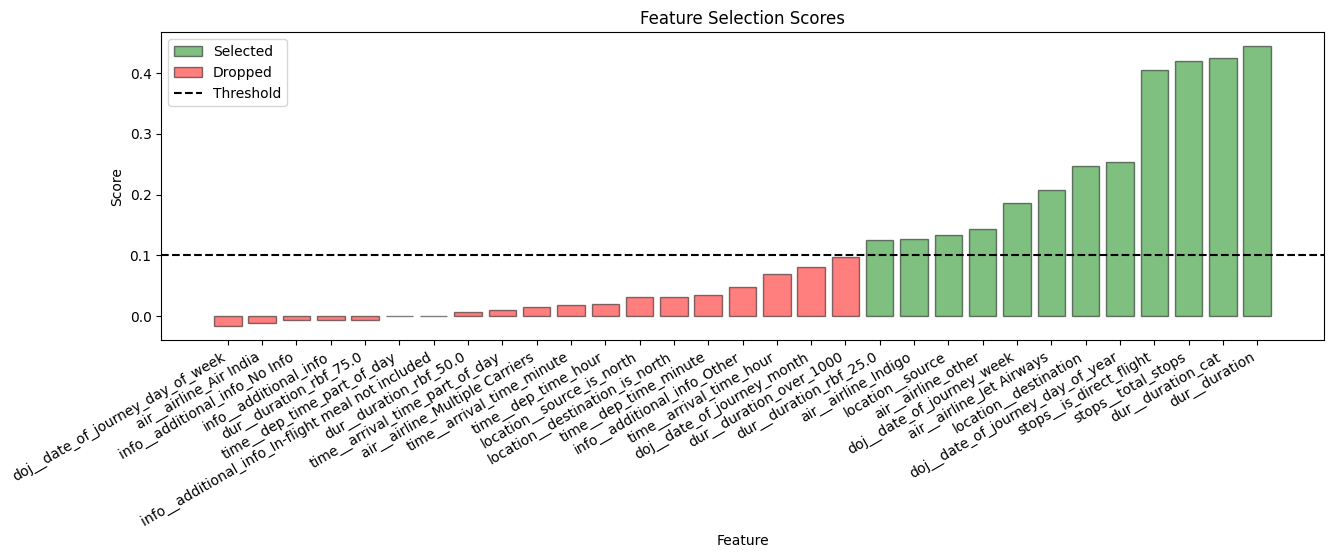

In [143]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 12 features out of that